### Preprocess

In [1]:
# Get the IMDB data:
!wget http://files.fast.ai/data/aclImdb.tgz

# Unzip the tgz file, and put it in the right directory:
# x for extract
# -v for verbose    # NOTE: I usually turn this off; it prints a lot...
# -z for gnuzip
# -f for file (should come at last just before file name)
# -C to extract the zipped contents to a different directory
!tar -xvzf aclImdb.tgz

# Make sure the data is where we think it is:
!ls aclImdb
!rm aclImdb.tgz

串流輸出內容已截斷至最後 5000 行。
aclImdb/train/all/28670_0.txt
aclImdb/train/all/14519_0.txt
aclImdb/train/all/48120_0.txt
aclImdb/train/all/20031_0.txt
aclImdb/train/all/2931_10.txt
aclImdb/train/all/9284_1.txt
aclImdb/train/all/40656_0.txt
aclImdb/train/all/5204_1.txt
aclImdb/train/all/29504_0.txt
aclImdb/train/all/33629_0.txt
aclImdb/train/all/18666_0.txt
aclImdb/train/all/27700_0.txt
aclImdb/train/all/637_10.txt
aclImdb/train/all/11969_0.txt
aclImdb/train/all/5906_0.txt
aclImdb/train/all/29267_0.txt
aclImdb/train/all/6474_0.txt
aclImdb/train/all/7194_1.txt
aclImdb/train/all/41085_0.txt
aclImdb/train/all/45783_0.txt
aclImdb/train/all/11592_10.txt
aclImdb/train/all/800_0.txt
aclImdb/train/all/6014_0.txt
aclImdb/train/all/18761_0.txt
aclImdb/train/all/8983_0.txt
aclImdb/train/all/47375_0.txt
aclImdb/train/all/7373_0.txt
aclImdb/train/all/4017_1.txt
aclImdb/train/all/22454_0.txt
aclImdb/train/all/39954_0.txt
aclImdb/train/all/7413_0.txt
aclImdb/train/all/6361_0.txt
aclImdb/train/all/3593_8.txt
acl

In [2]:
!pip install transformers
import torch
import sys
import re
import os
import random
import numpy as np
import pandas as pd
from torch import optim
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertForSequenceClassification, BertTokenizer

In [3]:
def init_seeds(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # Sets the seed for generating random numbers.
    torch.manual_seed(seed)
    # Sets the seed for generating random numbers for the current GPU.
    torch.cuda.manual_seed(seed)
    # Sets the seed for generating random numbers on all GPUs.
    torch.cuda.manual_seed_all(seed)


def clean(sentence):
    # Removing html tags
    sentence = re.sub(r'<[^>]+>', '', sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence


# read file
def read(path, seg):
    classes = ['pos', 'neg']
    data = []
    for c in classes:
        files = os.listdir(os.path.join(path, seg, c))
        for f in files:
            if f == ".DS_Store":
                continue
            with open(os.path.join(path, seg, c, f), 'r', encoding="utf8", errors="ignore") as rf:
                review = rf.read().replace('\n', '')
                if c == 'pos':
                    data.append([clean(review), 1])
                elif c == 'neg':
                    data.append([clean(review), 0])
                else:
                    return sys.exit(1)
    return data


class ImbdDataset(Dataset):
    def __init__(self, mode, sen_len, tokenizer):
        assert mode in ["train", "test"]
        self.mode = mode
        self.df = read('aclImdb', mode)
        self.len = len(self.df)
        self.maxlen = sen_len
        self.tokenizer = tokenizer  # bert tokenizer

    def __getitem__(self, index):
        origin_text = self.df[index][0]

        if self.mode == "train":
            text_a = self.df[index][0]
            text_b = None  # for natural language inference
            label_id = self.df[index][1]
            label_tensor = torch.tensor(label_id)
        else:
            text_a = self.df[index][0]
            text_b = None
            # label_tensor = None  #in our case, we have label
            label_id = self.df[index][1]
            label_tensor = torch.tensor(label_id)

        # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
        if text_b is None:
            # 建立第一個句子的 BERT tokens
            word_pieces = ["[CLS]"]
            tokens_a = self.tokenizer.tokenize(text_a)
            word_pieces += tokens_a[:self.maxlen] + ["[SEP]"]
            len_a = len(word_pieces)

            # 將整個 token 序列轉換成索引序列
            ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
            tokens_tensor = torch.tensor(ids)

            # 我們的task只有一個句子，所以segments_tensor的部分會全部給1
            segments_tensor = torch.tensor([1] * len_a, dtype=torch.long)
        else:
            word_pieces = ["[CLS]"]
            tokens_a = self.tokenizer.tokenize(text_a)
            word_pieces += tokens_a[:self.maxlen] + ["[SEP]"]
            len_a = len(word_pieces)

            # 多這一行
            tokens_b = self.tokenizer.tokenize(text_b)
            word_pieces += tokens_b + ["[SEP]"]
            len_b = len(word_pieces) - len_a

            ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
            tokens_tensor = torch.tensor(ids)

            segments_tensor = torch.tensor([0] * len_a + [1] * len_b, dtype=torch.long)

        return tokens_tensor, segments_tensor, label_tensor, origin_text

    def __len__(self):
        return self.len


# 建立pytorch dataloader 來一次取一個batch的資料
# collate_fn: 如何將多個樣本的資料連成一個batch丟進 model
# 截長補短後要限制attention只注意非pad 的部分
def create_mini_batch(samples):
    """
    :param: ImbdDataset的回傳值
            - tokens_tensor  : samples[0]
            - segments_tensor: samples[1]
            - label_tensor   : samples[2]
            - origin_text    : samples[3]
    :return: 訓練 BERT 時會需要的 4 個 tensors
            - tokens_tensors  : (batch_size, max_seq_len_in_batch)
            - segments_tensors: (batch_size, max_seq_len_in_batch)
            - masks_tensors   : (batch_size, max_seq_len_in_batch)
            - label_ids       : (batch_size)
    """
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    # 訓練集有 labels
    if samples[0][2] is not None:
        # 當dim = 0，原來的每一個矩陣也變成了一個維度
        # 一個矩陣看做一個整體，有幾個矩陣，新的維度就是幾，第幾個矩陣就是第幾維
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None

    # zero pad到該batch下最長的長度
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, segments_tensors, masks_tensors, label_ids

In [4]:
import matplotlib.pyplot as plt

# plot
plt_train_loss = []
plt_val_loss = []
plt_train_acc = []
plt_val_acc = []


def plot():
    # Loss曲線
    plt.plot(plt_train_loss)
    plt.plot(plt_val_loss)
    plt.title('Loss')
    plt.legend(['train', 'val'])
    plt.savefig('loss.png')
    plt.show()

    # Accuracy曲線
    plt.plot(plt_train_acc)
    plt.plot(plt_val_acc)
    plt.title('Accuracy')
    plt.legend(['train', 'val'])
    plt.savefig('acc.png')
    plt.show()

### Train

In [5]:
def train(batch_size, num_epoch, lr, model_dir, train, valid, model, device, MODELNAME, save_model=True):
    t_batch = len(train)
    v_batch = len(valid)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_acc = 0.0

    for epoch in range(num_epoch):
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        model.train()
        for i, data in enumerate(train):
            tokens_tensors, segments_tensors,masks_tensors, labels = [t.to(device) for t in data]
            optimizer.zero_grad()
            outputs = model(input_ids=tokens_tensors,
                            token_type_ids=segments_tensors,
                            attention_mask=masks_tensors,
                            labels=labels)

            # outputs return: loss, logits, hidden_states, attentions
            loss = outputs[0]
            loss.backward()
            optimizer.step()

            logits = outputs[1]
            _, pred = torch.max(logits.data, 1)
            train_acc += accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
            train_loss += loss.item()
            print('[ Epoch-{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
                epoch + 1, i + 1, t_batch, loss.item(), train_acc / batch_size))

        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(train_loss / t_batch, train_acc / t_batch * 100))

        # validation
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid):
                tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
                outputs = model(input_ids=tokens_tensors,
                                token_type_ids=segments_tensors,
                                attention_mask=masks_tensors,
                                labels=labels)

                loss = outputs[0]
                logits = outputs[1]
                _, pred = torch.max(logits.data, 1)
                val_acc += accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
                val_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(val_loss / v_batch, val_acc / v_batch * 100))

            # plot
            plt_train_acc.append(train_acc / (t_batch * 100))
            plt_train_loss.append(train_loss / t_batch)
            plt_val_acc.append(val_acc / (v_batch * 100))
            plt_val_loss.append(val_loss / v_batch)

            if val_acc > best_acc:
                best_acc = val_acc
                if save_model:
                    torch.save(model, "{}/".format(model_dir) + MODELNAME + ".model")
                print('saving model with acc {:.3f}'.format(val_acc / v_batch * 100))

        print('-----------------------------------------------')

### Test

In [6]:
def test(test, model, device, flag):
    model.eval()
    ret_output = []
    t_batch = len(test)
    test_acc = 0.0

    with torch.no_grad():
        for data in test:
            tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
            val_outputs = model(input_ids=tokens_tensors,
                                token_type_ids=segments_tensors,
                                attention_mask=masks_tensors,
                                labels=labels)

            logits = val_outputs[1]
            _, pred = torch.max(logits.data, 1)
            test_acc += accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
            
            output = pred
            output[output >= 0.5] = 1 # 大於等於 0.5 為正面
            output[output < 0.5] = 0 # 小於 0.5 為負面
            ret_output += output.cpu().tolist()
        print("Predict | Acc: {:.3f} ".format(test_acc / t_batch * 100))

    return ret_output

### Main

In [7]:
# Hyperparameters
sen_len = 300
batch_size = 16
num_labels = 2
epoch = 2
lr = 5e-5

In [8]:
# initialize Dataset
init_seeds()
print("read data...")
PRETRAINED_MODEL_NAME = "bert-base-uncased"  # 英文pretrain(不區分大小寫)
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
trainset = ImbdDataset("train", sen_len, tokenizer=tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# split val from trainset
val_size = int(trainset.__len__() * 0.04)  # 比對LSTM 切出1000筆當validation
trainset, valset = random_split(trainset, [trainset.__len__() - val_size, val_size])
print('trainset size:', trainset.__len__())
print('valset size:', valset.__len__())

read data...
trainset size: 24000
valset size: 1000


In [9]:
# 初始化一個每次回傳 batch size 個訓練樣本的 DataLoader
# collate_fn: 將 list of samples 合併成一個 mini-batch, size of tensor -->[16, 150 + 2]
train_loader = DataLoader(trainset, batch_size=batch_size, collate_fn=create_mini_batch, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, collate_fn=create_mini_batch, shuffle=False)

# 單一句子分類的FINETUNE_TASK是歸類在 bertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=num_labels)
model = model.to(device)
model_dir = "./"

print("\nstart training...")
train(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device, MODELNAME="test")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


start training...
[ Epoch-1: 1/1500 ] loss:0.775 acc:0.023 
[ Epoch-1: 2/1500 ] loss:0.693 acc:0.059 
[ Epoch-1: 3/1500 ] loss:0.829 acc:0.078 
[ Epoch-1: 4/1500 ] loss:0.701 acc:0.105 
[ Epoch-1: 5/1500 ] loss:0.706 acc:0.137 
[ Epoch-1: 6/1500 ] loss:0.660 acc:0.172 
[ Epoch-1: 7/1500 ] loss:0.675 acc:0.199 
[ Epoch-1: 8/1500 ] loss:0.763 acc:0.223 
[ Epoch-1: 9/1500 ] loss:0.681 acc:0.254 
[ Epoch-1: 10/1500 ] loss:0.649 acc:0.301 
[ Epoch-1: 11/1500 ] loss:0.620 acc:0.355 
[ Epoch-1: 12/1500 ] loss:0.671 acc:0.387 
[ Epoch-1: 13/1500 ] loss:0.645 acc:0.426 
[ Epoch-1: 14/1500 ] loss:0.617 acc:0.469 
[ Epoch-1: 15/1500 ] loss:0.680 acc:0.504 
[ Epoch-1: 16/1500 ] loss:0.699 acc:0.531 
[ Epoch-1: 17/1500 ] loss:0.685 acc:0.566 
[ Epoch-1: 18/1500 ] loss:0.651 acc:0.605 
[ Epoch-1: 19/1500 ] loss:0.667 acc:0.645 
[ Epoch-1: 20/1500 ] loss:0.671 acc:0.688 
[ Epoch-1: 21/1500 ] loss:0.687 acc:0.719 
[ Epoch-1: 22/1500 ] loss:0.622 acc:0.762 
[ Epoch-1: 23/1500 ] loss:0.677 acc:0.793 
[

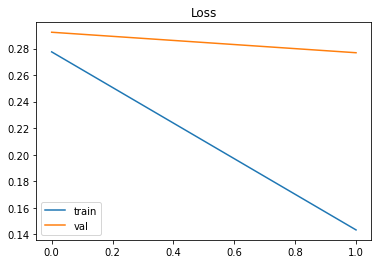

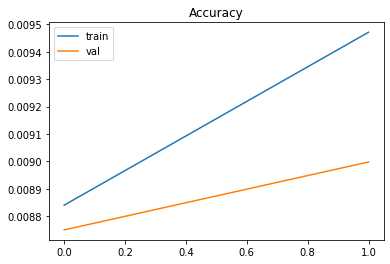

In [10]:
plot()

In [11]:
init_seeds()
print("read data...")
testset = ImbdDataset("test", sen_len, tokenizer=tokenizer)
print('testset size:', testset.__len__())
print("-"*20)

print("create DataLoader...")
test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=create_mini_batch, shuffle=False)

print('load model ...')
model = torch.load(os.path.join(model_dir, 'test.model'))
outputs = test(test_loader, model, device, "test")

pos = 0
neg = 0
num = len(outputs)
for i, o in enumerate(outputs):
    if i < num / 2 and o != 1:
        pos += 1
    if i > num / 2 and o != 0:
        neg += 1
print("number of comments which should be positive: ", pos)
print("number of comments which should be negative: ", neg)

read data...
testset size: 25000
--------------------
create DataLoader...
load model ...
Predict | Acc: 91.199 
number of comments which should be positive:  736
number of comments which should be negative:  1464


In [12]:
tmp = pd.DataFrame({"id": [str(i) for i in range(testset.__len__())], "label": outputs})
print("save csv ...")
path_prefix = "./"
tmp.to_csv(os.path.join(path_prefix, 'test.csv'), index=False)
print("Finish Predicting")

save csv ...
Finish Predicting


In [13]:
from google.colab import files
files.download('test.model')
files.download('acc.png')
files.download('loss.png')
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>